## Predicting Price with Size, Location, and Neighborhood

In [84]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [98]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # drop featues with high null counts
    df.drop(columns=["floor","expenses"], inplace=True)
    
    #drop low high cardinility
    df.drop(columns=["operation","property_type", "currency","properati_url"], inplace=True)

    # drop leckage
    df.drop(columns=['price', 'price_aprox_local_currency',  'price_per_m2', 'price_usd_per_m2'], inplace=True)
    
    # drop col with multi lineraity
    df.drop(columns=["rooms","surface_total_in_m2"], inplace=True)
    return df

In [86]:
files = glob("data/buenos-aires-real-estate-*.csv") 
files


['data/buenos-aires-real-estate-3.csv',
 'data/buenos-aires-real-estate-2.csv',
 'data/buenos-aires-real-estate-1.csv',
 'data/buenos-aires-real-estate-5.csv',
 'data/buenos-aires-real-estate-4.csv']

In [87]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index=True)   
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,120000.0,55.0,-34.616004,-58.470506,Villa General Mitre
1,89000.0,37.0,-34.584712,-58.444927,Palermo
2,183495.0,57.0,-34.554652,-58.493644,Saavedra
3,95000.0,47.0,-34.610581,-58.479625,Villa del Parque
4,95000.0,35.0,-34.558227,-58.458357,Belgrano


# Explore missing values , cardinility 

In [88]:
df.isnull().sum()

price_aprox_usd            0
surface_covered_in_m2      0
lat                      266
lon                      266
neighborhood               0
dtype: int64

In [89]:
df.select_dtypes(include="object").head()

,neighborhood
0,Villa General Mitre
1,Palermo
2,Saavedra
3,Villa del Parque
4,Belgrano


In [90]:
df.select_dtypes(include="object").nunique()

neighborhood    57
dtype: int64

In [91]:
sorted(df.columns)


['lat', 'lon', 'neighborhood', 'price_aprox_usd', 'surface_covered_in_m2']

<Axes: >

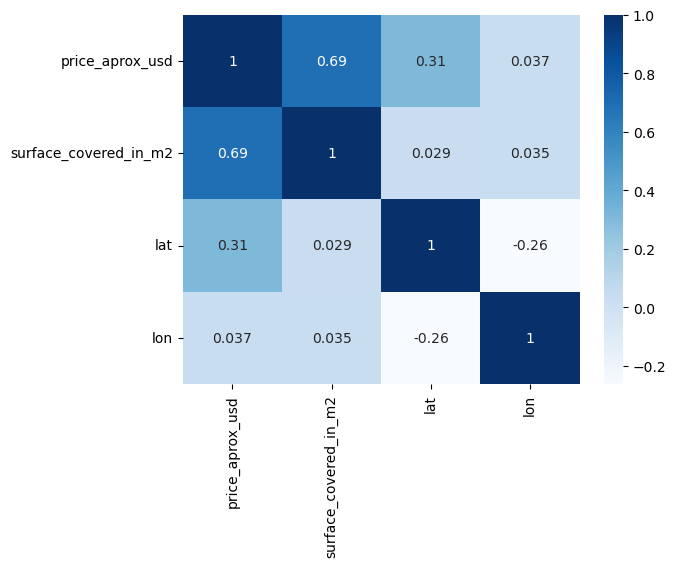

In [92]:
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, cmap="Blues", annot=True)


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_total_in_m2    4752 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   rooms                  5286 non-null   float64
 3   lat                    6316 non-null   float64
 4   lon                    6316 non-null   float64
 5   neighborhood           6582 non-null   object 
dtypes: float64(5), object(1)
memory usage: 308.7+ KB


In [94]:
target = "price_aprox_usd"
features = ["surface_covered_in_m2"]

X_train = df[features]
y_train = df[target]

y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(df)
print("Mean apt price " ,y_mean)
print("Baseline price " ,mean_absolute_error(y_train, y_pred_baseline))

Mean apt price  132383.83701458524
Baseline price  44860.10834274133


In [96]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LinearRegression()
)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

print("Mean apt price " ,y_mean)
print("Baseline price " ,mean_absolute_error(y_train, y_pred_baseline))

Mean apt price  132383.83701458524
Baseline price  44860.10834274133


In [97]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Mean apt price " ,y_mean)
print("Baseline price " ,mean_absolute_error(y_train, y_pred_baseline))
print("Training MAE " ,mae_training)



Mean apt price  132383.83701458524
Baseline price  44860.10834274133
Training MAE  30503.36225845516
